# Title: Brain MRI tumor detection 
## Instructor: Dr. Ryan White
## Course: MTH 4320
## Student: Giulio Martini

### Descrption:
  Cancer of the brain can be divided into several types, although each illness has the characteristic of being terribly aggressive. Manual detection of brain tumors can be extremely difficult, even for trained professionals, as the different kinds of disease surely look alike. An MRI (Magnetic Resonance Imaging) provides doctors and physicians with a highly specialized and detailed image, representing a cut-section of the brain (although it can be used for different parts of the body).

  The goal of this project is to identify three different types of brain tumors. The model must differentiate each individual type among these three different, and must also differentiate between an ill brain, and a healthy one. The dataset is small, about 3200 images for training, and 800 for testing, and the structure that shall be used, the Convolutional Neural Network,never performs well with a small dataset. That is where the real challenge lies: obtaining sufficient accuracy from a small dataset. 

  The baseline of this project will be a standard CNN that shall test whether a brain is ill or not. The model will be perfected, and the new hyperparameters will then be used to distinguish between types of illness.

### Methodology used
  To correctly analyze, and choose, the correct hyperparameters for a more complete predictio and classification, the perfect baseline Convolutional Neural Network will be built for classifying only whether an MRI presents a tumor or not. Using the same hyperparameters, a 4 class Convolutional Neural Netwoek will be built and the results will be observed. I expect some minor 'tweaks' will need to be performed. After building a standard neural network, two different Transfer NNs will be compared. The mentioned Transfer models will be 'effnetb0' and 'vgg16', which were the best performing transfer networks in the previous assignment (Homework #3). After that, more esploratory work will be  done using the 'Gradcam' method, and an interactive widget will be implemented so one could insert their own MRI image. 

### Input values
  The input values that will be given to the function will be close to 3500 images, which will be rescaled according to the model (transfer model sometimes require specific measurements). The images are classified in the following manner: 
- Training -> no_tumor, meningioma_tumor, pituary_tumor, glioma_tumor
- Testing -> no_tumor, meningioma_tumor, pituary_tumor, glioma_tumor

### Output
  For intermediary models, only validation accuracy will be displayed. Validation data will be just a split of the training data. After compiling a line plot, hyperparameters will either remain the same, or will be changed.

  For final models, a line plot, testing accuracy, a classification report and, most importantly, a heatmpa will be compiled, in order to determine how the models did and check for any discrepancies in the data.

### Notes
  The data will have to be downloaded in two different ways: one for the bicategorical testing, and one for the quadricategorical testing. To the best of my knowledge, and for the simplicity of the model, along with keeping the focus on designing a model, two different methods will be implemented. 





In [1]:
from google.colab import drive  # As we are working with google drive and google colab, the files are downloaded to a local drive and the Colab notebook must be connected to it. 
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [25]:
# Integral functions to have for the execution of the project.
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,preprocessing
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras import layers,models,optimizers,preprocessing, Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

### Visualizations
  Below are provided visualizations of the different types of tumors and how they show, along with the different class names and how the tumors differentiate, alogn with visualziationg how the different categories are distributed. 

In [3]:
from fastai.data.all import *#  Fastai is a library used for more advanced visualization, easier to use than seaborn. 
from fastai.vision.all import *


categories = DataBlock(blocks=(ImageBlock, CategoryBlock),get_items=get_image_files,get_y=parent_label,splitter = RandomSplitter(valid_pct=0.2, seed=42),item_tfms=RandomResizedCrop(224, min_scale=0.5),batch_tfms=aug_transforms())

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


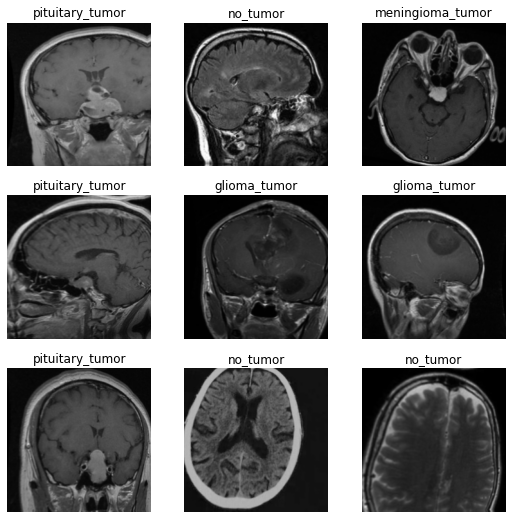

In [4]:
directory_download = categories.dataloaders(r'/content/gdrive/MyDrive/Notebooks/NNProject2') # Different images are downloaded, and a batch s showd. 
print(directory_download.vocab)
directory_download.show_batch()

### First glance
  While all the different tumors are highly differentiable, it can be inferred that the models will have a somewhat hard time predicting between a healthy brain and glioma cancer, as there not a lot of indicators for the tumor's presence. In addition, pituary tumor can be harder to differentiate than meningioma, as they present the same color, albeit different locations. 

In [ ]:
#   Downloading the dataset for bicategorical classification

colab_directory = r'/content/gdrive/MyDrive/Notebooks/NNProject2'
binary_classification = [("no_tumor",), ("meningioma_tumor",)]
resolution = 64

def load_images(root_dir_name):
    images_array = []
    images_labels = []
    
    for label, quadri_classification in enumerate(binary_classification):
        for tumor in quadri_classification:
            print(f"loading {root_dir_name} {tumor}")
            tumor_path = os.path.join(colab_directory, root_dir_name, tumor)
            for image_name in os.listdir(tumor_path):
                image_path_drive = os.path.join(tumor_path, image_name)
                image = preprocessing.image.load_img(image_path_drive, color_mode="grayscale", target_size=(resolution, resolution)) #  Image is set to grayscale (value of 1) for semplicity and because a basic CNN model easily accepts it. 
                images_array.append(preprocessing.image.img_to_array(image))
                images_labels.append(label)
    
    #  IMAGE NORMALIZATION 
    images_array = np.array(images_array) / 255.0 # Images are then normalized 
    images_labels = np.array(images_labels)
    
    #  The function returns two arrays.
    return images_array, images_labels


In [8]:
# Splits have occured.
x_train, y_train = load_images("Training")
x_test, y_test = load_images("Testing")

loading Training no_tumor
loading Training meningioma_tumor
loading Testing no_tumor
loading Testing meningioma_tumor


### File count
  The following snippet of code will display the number of files from each class, so a better understanding can be achieved of how the model will work. 

In [9]:
image_number = 0
training_set = {"no_tumor": 0, "glioma_tumor" : 0, "meningioma_tumor": 0, "pituitary_tumor":0} #  Dictionary datasets used in order to perform the file count
testing_set = {"no_tumor": 0, "glioma_tumor" : 0, "meningioma_tumor": 0,  "pituitary_tumor":0}


for tumor_class in os.listdir(colab_directory):   # The following for loop iterates through all the file and, using the dictionary above, counts the correct number of images per class. 
    if tumor_class == "Training":
        for category in os.listdir(os.path.join(colab_directory, tumor_class)):
            for file_name in os.listdir(os.path.join(colab_directory, tumor_class, category)):
                training_set[category] += 1
                image_number = image_number + 1     

    if tumor_class == "Testing":
        for category in os.listdir(os.path.join(colab_directory, tumor_class)):
            for file_name in os.listdir(os.path.join(colab_directory, tumor_class, category)):
                testing_set[category] += 1
                image_number = image_number + 1     

total_dict = {}
for tumor_class in training_set.keys():
    total_dict[tumor_class] = training_set[tumor_class] + training_set[tumor_class]
    
print(image_number)
print(training_set)
print(testing_set)
print(total_dict)

3264
{'no_tumor': 395, 'glioma_tumor': 826, 'meningioma_tumor': 822, 'pituitary_tumor': 827}
{'no_tumor': 105, 'glioma_tumor': 100, 'meningioma_tumor': 115, 'pituitary_tumor': 74}
{'no_tumor': 790, 'glioma_tumor': 1652, 'meningioma_tumor': 1644, 'pituitary_tumor': 1654}


In [11]:
!pip install split-folders  # Installation of the splitfolder library. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import splitfolders
import PIL
splitfolders.ratio('/content/gdrive/MyDrive/Notebooks/NNProject2/Training',ratio=(0.8,0.2)) #   Them  folder will split the training set in 80% testing and 20% validation. 

Copying files: 2870 files [00:34, 84.12 files/s] 


In [18]:
testing_path = os.path.join('/content/gdrive/MyDrive/Notebooks/NNProject2','Testing') # The testing set will subsequently be split, nd
training_path = './output/train'
validation_path = './output/val'

In [19]:
values = {'training':[], 'Testing':[], 'Validation':[]} #   Dictionaries containing the different sets that shall be given to the paths
labels = {'Training':[], 'Testing':[], 'Validation':[]}


for phase in ['train','val','test']:
    if phase == 'train':
        main_dir = training_path
    elif phase == 'val':
        main_dir = validation_path
    else:
        main_dir = testing_path
    class_names = sorted(x for x in os.listdir(main_dir)
                            if os.path.isdir(os.path.join(main_dir, x)))
    num_class = len(class_names) 
    image_files = [
        [
            os.path.join(main_dir, class_names[i], x)
            for x in os.listdir(os.path.join(main_dir, class_names[i]))
        ]
        for i in range(num_class)
    ]
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    values[phase] = image_files_list
    labels[phase] = image_class
    num_total = len(image_class)
    image_width = 64  # The resolution of the images is set to be the same as before. 
    image_height = 64

([<matplotlib.patches.Wedge at 0x7fc8a2c65390>,
 [Text(0.8652224728010165, 0.6792570003762157, 'glioma_tumor'),
  Text(0.4558350953520076, -1.0011065706733857, 'meningioma_tumor'),
  Text(-1.0792659906673636, -0.21256745138612876, 'no_tumor'),
  Text(-0.4613122046984333, 0.998594537235344, 'pituitary_tumor')],
 [Text(0.4719395306187362, 0.37050381838702673, '28.8%'),
  Text(0.24863732473745864, -0.5460581294582103, '28.8%'),
  Text(-0.5886905403640165, -0.11594588257425203, '28.6%'),
  Text(-0.2516248389264181, 0.5446879294010967, '13.8%')])

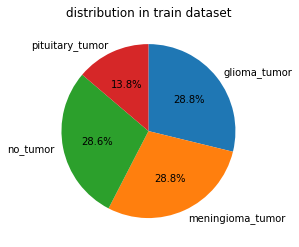

In [20]:
# Set is converted to a dataframe, which helps with the pie chart plotting. 
tumor_set = pd.DataFrame({'path': values['train'],'label': labels['train']})
sorted_counts  = tumor_set.value_counts('label')
plt.title('distribution in train dataset')
plt.pie(sorted_counts, labels = class_names,  startangle = 90, autopct="%.1f%%")

### Visualization notes
  After the piechart has been constructed, the images outputted and the numbers displayed, it can be obsered that the split of meningioma affected, glioma affected and healthy individuals is uniform, both in testing and training. People affected by pituitary tumor are less represented, although they still represent more than 10% of the patients. This could represent a problem for their classification, however the position of the tumor is quite unique. It is fortunate that 'glioma' is represented as much as it is, since it can be easily confused with a healthy person. 

### Tumor vs No Tumor
  The first section of the project takes place. The tumor type that is chosen is 'meningioma'. Meningioma is chosen for the following reasons: 
- It is prevalent amongst the provided files
- It is easily recognizable for its general size
- It is easily recognizable for its milky color

  These characteristics allow it to be the perfect candidate for a preliminary classification model. 


In [32]:
from tensorflow.keras import layers,models,optimizers,preprocessing, Sequential
import seaborn as sb
# The following functions is used to display two line plots following each model. It will display both the accuracy and loss of training and testing, keeping the epoch number as the 'x' of the plots. 
def showModel(history):
  epochs = [i for i in range(20)]
  figure, ax = plt.subplots(1,2,figsize=(14,7))
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  figure.text(s='Accuracy and validation loss for training and testing', size=16, fontweight='bold', fontname='monospace', y=1,x=0.28,alpha=0.8)

  sb.despine()
  ax[0].plot(epochs, train_acc,label = 'Training Accuracy')
  ax[0].plot(epochs, val_acc,label = 'Validation Accuracy')
  ax[0].legend(frameon=False)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  sb.despine()
  ax[1].plot(epochs, train_loss, label ='Training Loss')
  ax[1].plot(epochs, val_loss, label = 'Validation Loss')
  ax[1].legend(frameon=False)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training & Validation Loss')

  figure.show()

These last visualization help the user observe what a healthy brain resembles, and what a meningioma affected one looks like. The following snippet of code also downloads once again the correct dataset.

loading Training no_tumor
loading Training meningioma_tumor
loading Testing no_tumor
loading Testing meningioma_tumor


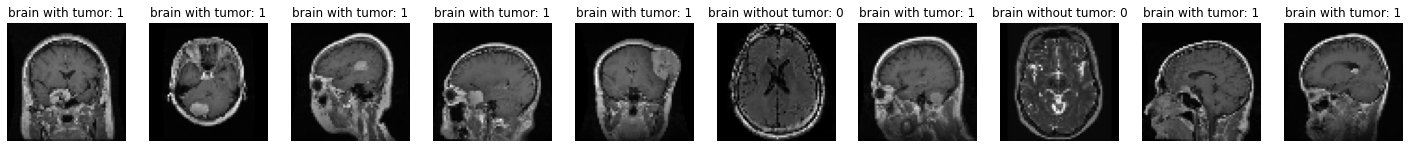

In [23]:
x_train, y_train = load_images("Training")
x_test, y_test = load_images("Testing")

figure, subplots = plt.subplots(1, 10)
figure.set_size_inches(25, 3)
for i in range(10):
    n = np.random.randint(0, len(x_train))
    class_numerical = y_train[n]
    condition = "out" if class_numerical == 0 else "" 
    
    subplots[i].imshow(x_train[n].reshape((64, 64)), cmap="gray")
    subplots[i].set_title(f"brain with{condition} tumor: {class_numerical}")
    subplots[i].axis("off")
plt.show()

### Baseline
  The following model is the first baseline. It has an initial ReLU activation, with the correct size. The size is 64x64 (previously mentioned resolution), followed by a 1, which indicates grayscale. The optimizer will be 'Adam' and the loss function will be 'binary crossentropy', as the model will differentiate between only two components. 

In [34]:

baseline = models.Sequential()
baseline.add(Conv2D(64,kernel_size = (2,2),activation = 'relu',input_shape = (64,64,1)))
baseline.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
baseline.add(Conv2D(64,kernel_size = (2,2),activation = 'relu'))
baseline.add(Flatten())
baseline.add(Dense(256, activation="relu"))
baseline.add(Dense(1, activation="softmax"))
baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               14745856  
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

In [27]:
baseline.compile(optimizer = 'adam',loss = "binary_crossentropy",metrics = ['accuracy'])

In [28]:
history = baseline.fit(x_train,y_train,batch_size = 5,epochs = 20, validation_split = 0.2)

Epoch 1/20
195/195 [==============================] - 26s 129ms/step - loss: 0.5050 - accuracy: 0.5940 - val_loss: 0.3501 - val_accuracy: 1.0000
Epoch 2/20
195/195 [==============================] - 27s 137ms/step - loss: 0.2886 - accuracy: 0.5940 - val_loss: 0.2533 - val_accuracy: 1.0000
Epoch 3/20
195/195 [==============================] - 28s 143ms/step - loss: 0.1634 - accuracy: 0.5940 - val_loss: 0.2009 - val_accuracy: 1.0000
Epoch 4/20
195/195 [==============================] - 29s 149ms/step - loss: 0.0828 - accuracy: 0.5940 - val_loss: 0.1709 - val_accuracy: 1.0000
Epoch 5/20
195/195 [==============================] - 25s 126ms/step - loss: 0.0499 - accuracy: 0.5940 - val_loss: 1.1721 - val_accuracy: 1.0000
Epoch 6/20
195/195 [==============================] - 26s 136ms/step - loss: 0.0269 - accuracy: 0.5940 - val_loss: 0.1885 - val_accuracy: 1.0000
Epoch 7/20
195/195 [==============================] - 34s 176ms/step - loss: 0.0166 - accuracy: 0.5940 - val_loss: 0.3731 - val_ac

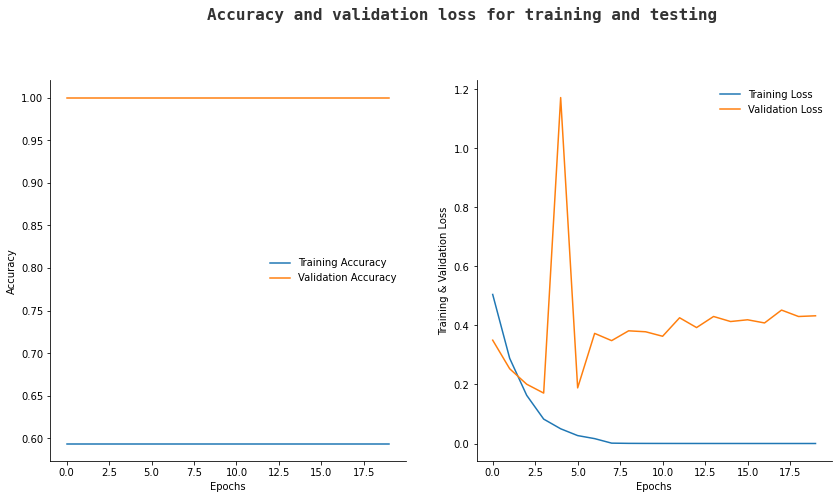

In [33]:
showModel(history)

### Considerations
  The baseline performance was underwhelming, however it gives the chance for a lot improvement. The training loss descended smoothyl, while the testing rose. Both the accuracy stayed in their place. 

  This model needs a radical change. Keeping the architecture the same (size wise), new activations functions will be tested to see how well they perform. 

### Model 2 
  This model differs in switching between ReLU and sigmoid. The architecture's size is invariate, with an output ReLU layer and the previous layers being sigmoid. The loss function, along with the optimizer, will be kept the same. 

In [35]:
model2 = models.Sequential()
model2.add(Conv2D(64,kernel_size = (2,2),activation = 'sigmoid',input_shape = (64,64,1)))
model2.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model2.add(Conv2D(64,kernel_size = (2,2),activation = 'sigmoid'))
model2.add(Flatten())
model2.add(Dense(256, activation="sigmoid"))
model2.add(Dense(1, activation="relu"))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               14745856  
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                      

In [16]:
model2.compile(optimizer = 'adam',loss = "binary_crossentropy",metrics = ['accuracy'])

In [ ]:
history = model2.fit(x_train,y_train,batch_size = 5,epochs = 20, validation_data=(x_test, y_test))

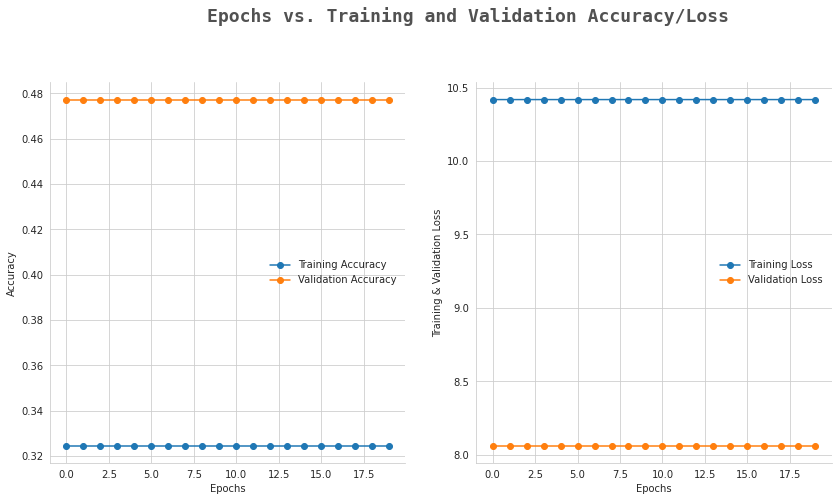

In [18]:
showModel(history)

### Considerations - Major mistake
  No matter the changes, the outcome looks the same. It actually looks worse, since the training loss did not fall. The mistake that was made was a major one: The output layers have all been comprised of 1 neuron, when that can only be achieved through a 'sigmoid' layers. I have been designing the last layer as a 'softmax' or 'ReLU'.

### Model 3
  Model 3 will keep the same architecture size, while changing the output layer to 'sigmoid', and the previous ones to 'linear', which have worked well for binary data in the past (and they take considerable less time to perform). 

In [36]:
model3 = models.Sequential()
model3.add(Conv2D(64,kernel_size = (2,2),activation = 'linear',input_shape = (64,64,1)))
model3.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model3.add(Conv2D(64,kernel_size = (2,2),activation = 'linear'))
model3.add(Flatten())
model3.add(Dense(256, activation="linear"))
model3.add(Dense(1, activation="sigmoid"))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 flatten_3 (Flatten)         (None, 57600)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               14745856  
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                      

In [20]:
model3.compile(optimizer = 'adam',loss = "binary_crossentropy",metrics = ['accuracy'])

In [ ]:
history = model3.fit(x_train,y_train,batch_size = 5,epochs = 20, validation_data=(x_test, y_test))

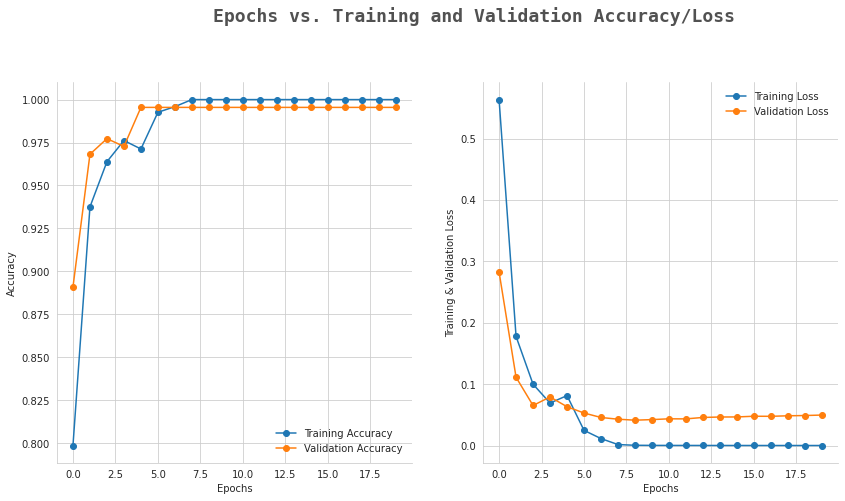

In [22]:
showModel(history)

### Considerations
  Model3 appears to be working quite well. The validation accuracy has reached highs of 0.995 and then staggered at the end. The training set reached a loss of 0 and an accuracy of 1.00. Validation accuracy and loss seem to have staggered at the end, and a small amount of overfitting happens near the conclusion of the training cycle. 

### Model 4 
  Model 4 will test a new optimizer: 'rmsprop', in order to reduce overfitting. Since it worked amazingly before, the architecture will be kept the same, along with activation functions. 

In [37]:
model4 = models.Sequential()
model4.add(Conv2D(64,kernel_size = (2,2),activation = 'linear',input_shape = (64,64,1)))
model4.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model4.add(Conv2D(64,kernel_size = (2,2),activation = 'linear'))
model4.add(Flatten())
model4.add(Dense(256, activation="linear"))
model4.add(Dense(1, activation="sigmoid"))
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 64)        16448     
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               14745856  
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                      

In [24]:
model4.compile(optimizer = 'rmsprop',loss = "binary_crossentropy",metrics = ['accuracy'])

In [ ]:
history = model4.fit(x_train,y_train,batch_size = 5,epochs = 20, validation_data=(x_test, y_test))

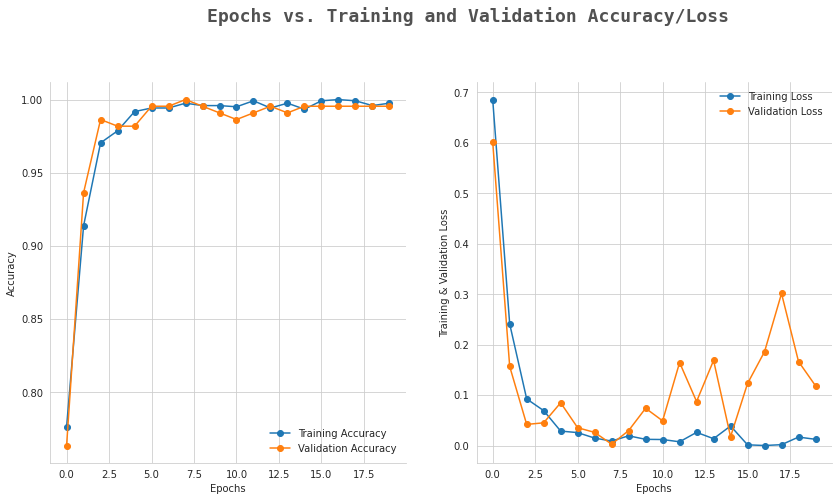

In [26]:
showModel(history)

### Considerations
  The 'rmsprop' loss did not perform as well as thought, so the model will revert back to 'Adam'. Even in Model3, some slight overfitting can be seen, along with accuracy staggering. The accuracy is high enough that the staggering can be excluded for further analysis, but there are many different ways which that overfitting can be addressed. 

### Model 5 
  Model5 will take Model3 and add more 'linear' activation functions to increase the accuracy, whilst also adding various dropout layers to successfully address the issue of overfitting. 



In [38]:
model5 = models.Sequential()
model5.add(Conv2D(64,kernel_size = (2,2),strides = (1,1),activation = 'linear',input_shape = (64,64,1)))
model5.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model5.add(Conv2D(64,kernel_size = (2,2),strides = (1,1),activation = 'linear'))
model5.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model5.add(Dropout(rate=0.3))
model5.add(Conv2D(128,kernel_size = (2,2),strides = (1,1),activation = 'linear'))
model5.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model5.add(Dropout(rate=0.3))
model5.add(Conv2D(256,kernel_size = (2,2),strides = (1,1),activation = 'linear'))
model5.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model5.add(Dropout(rate=0.3))
model5.add(Conv2D(256,kernel_size = (2,2),strides = (1,1),activation = 'linear'))
model5.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model5.add(Flatten())
model5.add(Dropout(0.5))
model5.add(Dense(256, activation="linear"))
model5.add(Dense(1, activation="sigmoid"))
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 64)        16448     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)      

### Notes
To further enhance Model5, callbacks will be implemented to reduce the learning rate based on the accuracy, and 'perfection' will be implemented to save the weights for further use (this is more experimental). If this model reaches 0.99% accuracy, it will be deemed the final and most successful

In [153]:
less_learning_rate=ReduceLROnPlateau(patience=2)
perfection = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
model5.compile(optimizer = 'Adam',loss = "binary_crossentropy",metrics = ['accuracy'])
history = model5.fit(x_train,y_train,batch_size = 5,epochs = 20, validation_data=(x_test, y_test), callbacks = [less_learning_rate, perfection])

Epoch 1/20
243/244 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.6905
Epoch 1: val_accuracy improved from -inf to 0.44545, saving model to effnet.h5
244/244 [==============================] - 18s 70ms/step - loss: 0.6326 - accuracy: 0.6910 - val_loss: 1.2101 - val_accuracy: 0.4455 - lr: 0.0010
Epoch 2/20
243/244 [============================>.] - ETA: 0s - loss: 0.4647 - accuracy: 0.7860
Epoch 2: val_accuracy improved from 0.44545 to 0.52727, saving model to effnet.h5
244/244 [==============================] - 16s 65ms/step - loss: 0.4640 - accuracy: 0.7864 - val_loss: 0.8614 - val_accuracy: 0.5273 - lr: 0.0010
Epoch 3/20
243/244 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8370
Epoch 3: val_accuracy improved from 0.52727 to 0.66364, saving model to effnet.h5
244/244 [==============================] - 15s 62ms/step - loss: 0.3767 - accuracy: 0.8373 - val_loss: 0.6583 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 4/20
243/244 [===========

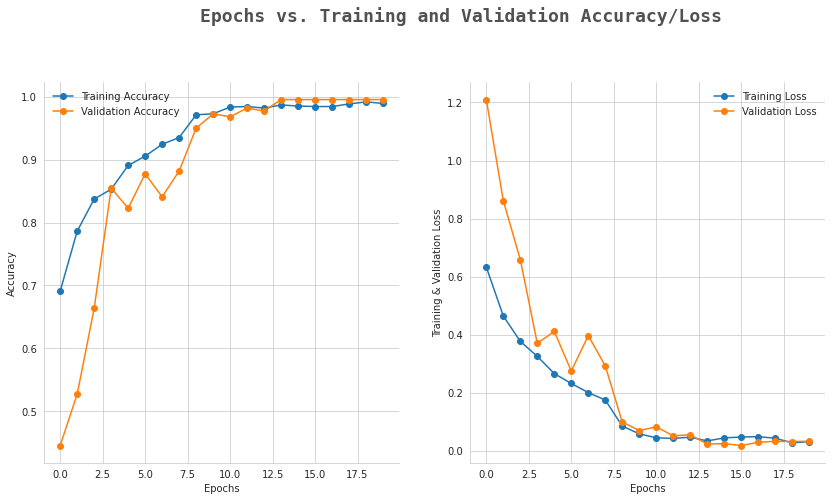

In [154]:
showModel(history)

 ### Considerations - Success
  Model5 reached its target point. It bested the training accuracy, reduced the overfitting and reduced the staggering of both loss and accuracy. This will be used for the quadriclassification model as well. Minor tweaks are to be expected. 

### Challenge: successfully migrate a biclassification model to a quadriclassification model

  As stated before, the data must be once again downloaded, although this time in the correct way, in order to properly differentiate between the different classes. 

In [39]:
def from_image_to_dataset(path, resolution):
    class_tumor=0
    image_dataset=pd.DataFrame()
    for category in glob(path+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(resolution, resolution))
            dataset=pd.DataFrame({'image':[img_array],'label':[class_tumor]})
            image_dataset=image_dataset.append(dataset)
        class_tumor+=1
    return image_dataset.sample(frac=1).reset_index(drop=True) # return a shuffled dataset

In [40]:
from glob import glob

train_data=from_image_to_dataset('/content/gdrive/MyDrive/Notebooks/NNProject2/Training', 224)  # the resolution is now placed to 224
train_x=np.array(train_data.image.to_list())

test_data=from_image_to_dataset('/content/gdrive/MyDrive/Notebooks/NNProject2/Testing', 224)
test_x=np.array(test_data.image.to_list())

100%|██████████| 74/74 [00:22<00:00,  3.27it/s]


### TPU use
  TPU are known as Tensorflow Processing Units and are similar to GPUs. Google Colab offers free TPUs on first come first serve basis for unpaid subscriptions of the service, and they significantly cut down on the run time of each model. Where before the runtime was 15 minutes per epoch, even when using GPUs, now it's little less than a minute and a half.

In [8]:
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU identification.
tf.config.experimental_connect_to_cluster(tpu)  # TPU connection.
tf.tpu.experimental.initialize_tpu_system(tpu)  # TPU initialization

tpu_strategy = tf.distribute.TPUStrategy(tpu) # The TPU has been initialized and is ready to use. 


### QuadriModel
  After successive experimental testing, the QuadriModel needed more improvements and tweaks than initially thought. Firstly, the output layer is changed from 1 neuron to 4, subsequentally the activation function is changed from sigmoid to softmax (works better than ReLU). Secondly, the activation functions are changed from 'Linear' to 'ReLU', as we are dealing with more than 2 classes. The loss function is also changed to 'sparse_categorical_crossentropy' as it gave a 3.7% boost in accuracy. Lastly, the number of layers is a little less, as it proved better with overfitting. 

The model must now recognize between four different classes, two of which are very similar, 3 of which are somewhat similar. 

In [41]:
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
quadri_model = Sequential()
quadri_model.add(Input(shape=(224,224,3)))
quadri_model.add(Conv2D(64,(3,3)))
quadri_model.add(MaxPooling2D((2,2)))
quadri_model.add(BatchNormalization())
quadri_model.add(Conv2D(64,(3,3)))
quadri_model.add(MaxPooling2D((2,2)))
quadri_model.add(BatchNormalization())
quadri_model.add(Conv2D(128,(3,3)))
quadri_model.add(MaxPooling2D((2,2)))
quadri_model.add(BatchNormalization())
quadri_model.add(Flatten())
quadri_model.add(Dense(128,activation = 'relu'))
quadri_model.add(Dropout(0.2))
quadri_model.add(Dense(256,activation = 'relu'))
quadri_model.add(Dense(4,activation = 'softmax'))

quadri_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                      

In [14]:
less_learning_rate=ReduceLROnPlateau(patience=2)
quadri_model.compile(optimizer = 'adam',loss = "sparse_categorical_crossentropy",metrics = ['accuracy'])
perfection = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1, patience = 2)
history = quadri_model.fit(train_x,train_data.label,batch_size = 5,epochs = 20, validation_split = 0.2, callbacks = [less_learning_rate, perfection])

Epoch 1/20
460/460 [==============================] - ETA: 0s - loss: 1.2247 - accuracy: 0.5414
Epoch 1: val_accuracy improved from -inf to 0.40070, saving model to vgg16.h5
460/460 [==============================] - 86s 184ms/step - loss: 1.2247 - accuracy: 0.5414 - val_loss: 1.8040 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 2/20
460/460 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.5793
Epoch 2: val_accuracy improved from 0.40070 to 0.55923, saving model to vgg16.h5
460/460 [==============================] - 85s 184ms/step - loss: 1.0037 - accuracy: 0.5793 - val_loss: 0.8985 - val_accuracy: 0.5592 - lr: 0.0010
Epoch 3/20
460/460 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.6363
Epoch 3: val_accuracy improved from 0.55923 to 0.66899, saving model to vgg16.h5
460/460 [==============================] - 85s 184ms/step - loss: 0.8286 - accuracy: 0.6363 - val_loss: 0.7364 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/20
460/460 [===========

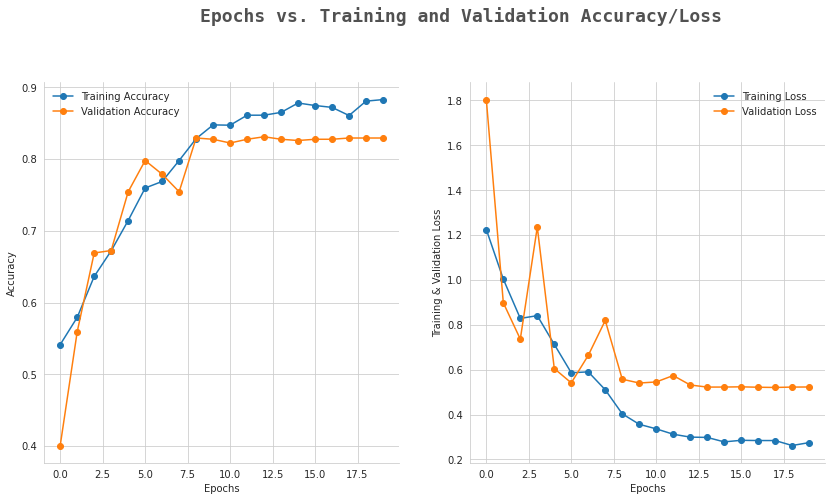

In [17]:
showModel(history)

In [19]:
from sklearn.metrics import classification_report

test_pred=np.argmax(quadri_model.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred))

13/13 [==============================] - 1s 91ms/step
              precision    recall  f1-score   support

           0       0.75      0.15      0.25       100
           1       0.54      0.74      0.62       115
           2       0.59      0.88      0.70       105
           3       0.78      0.64      0.70        74

    accuracy                           0.61       394
   macro avg       0.67      0.60      0.57       394
weighted avg       0.65      0.61      0.56       394



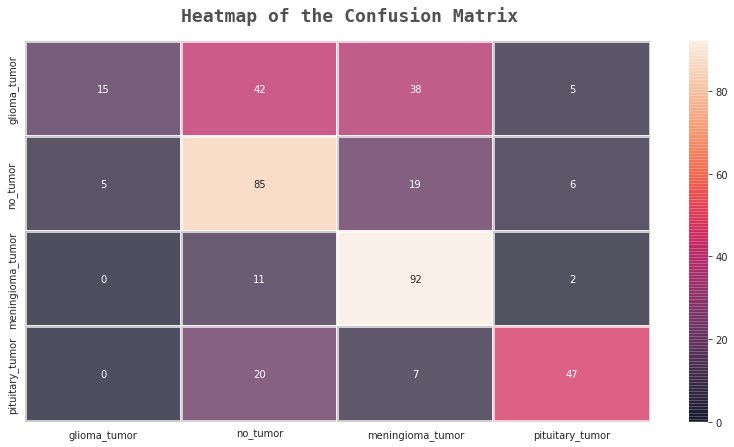

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
tumors = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
fig,ax=plt.subplots(1,1,figsize=(14,7))
sb.heatmap(confusion_matrix(test_data.label,test_pred), ax=ax, xticklabels=tumors, yticklabels=tumors, annot=True, alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold', fontname='monospace', y=0.92, x=0.28, alpha=0.8)
plt.show()

### Considerations
  The model did not perform as well as Model 5, although it was to be expected. The 'glioma_tumor' images are confused a lot with 'no_tumor' and 'meningioma_tumor'. This was predicted earlier, as the images are very similar and as there are not enough images in the dataset for the glioma tumor. The glioma tumor is made up only of about 300 images. I attribute the loss of accuracy to this, the images can be confused very easily. In addition, 'pituary_tumor' is somewhat confused with 'no_tumor', I imagine because of the shape of a pituary tumor, it's relative small shape and the darker coloring, while being sorrounded by lighter areas (brain stem). 

  With all of these limitations in mind, I imagine this to be a partial success. It could have been better, but there weren't enough images. Given a dataset 10 times the size, I'm sure the accuracy and loss would improve immensely. 

### TRANSFER Model
  In order to try and boost the accuracy, two transfer models will be implemented. The first one will be an EfficientNetB0, with the weights from Imagenet, while the second will be a VGG16 model, with the weights still from Imagenet (provided in another notebook). The TPU will be used, as each epoch takes 20 minutes normally, and fewer layers will be added to prevent overfitting, whilst also adding dropout. The output layer will be a softmax with 4 outputs. I'm expecting better results, especially in differentiating between the glioma and meningioma tumor, which is the biggest problem. The compile hyperparameters will be kept the same as for the QuadriModel, but the resolution is changed to 150, and it will be shifted to 'rgb' (3), since it's what the model requires. 

In [42]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3))

16705208/16705208 [==============================] - 0s 0us/step


In [44]:
effnet_model = effnet.output
effnet_model = tf.keras.layers.GlobalAveragePooling2D()(effnet_model)
effnet_model = tf.keras.layers.Dropout(rate=0.3)(effnet_model)
effnet_model = tf.keras.layers.Dense(4,activation='softmax')(effnet_model)
effnet_model = tf.keras.models.Model(inputs=effnet.input, outputs = effnet_model)
effnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [51]:
effnet_model.compile(loss='sparse_categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [53]:
less_learning_rate=ReduceLROnPlateau(patience=2)
perfection = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [36]:
from glob import glob

train_data=from_image_to_dataset('/content/gdrive/MyDrive/Notebooks/NNProject2/Training', 150)
train_x=np.array(train_data.image.to_list())

test_data=from_image_to_dataset('/content/gdrive/MyDrive/Notebooks/NNProject2/Testing', 150)
test_x=np.array(test_data.image.to_list())

100%|██████████| 74/74 [00:01<00:00, 71.11it/s]


In [54]:
history = effnet_model.fit(train_x,train_data.label,validation_split=0.1, epochs =20, verbose=1, batch_size=32, callbacks = [perfection, less_learning_rate])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9876
Epoch 1: val_accuracy improved from -inf to 0.98258, saving model to effnet.h5
81/81 [==============================] - 42s 517ms/step - loss: 0.0504 - accuracy: 0.9876 - val_loss: 0.0523 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9845
Epoch 2: val_accuracy did not improve from 0.98258
81/81 [==============================] - 66s 810ms/step - loss: 0.0455 - accuracy: 0.9845 - val_loss: 0.3007 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9752
Epoch 3: val_accuracy did not improve from 0.98258
81/81 [==============================] - 65s 802ms/step - loss: 0.0775 - accuracy: 0.9752 - val_loss: 0.0805 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9934
Epoch 4:

In [56]:
test_pred=np.argmax(effnet_model.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred))

13/13 [==============================] - 5s 290ms/step
              precision    recall  f1-score   support

           0       1.00      0.25      0.40       100
           1       0.66      1.00      0.79       115
           2       0.77      1.00      0.87       105
           3       0.96      0.74      0.84        74

    accuracy                           0.76       394
   macro avg       0.85      0.75      0.73       394
weighted avg       0.83      0.76      0.72       394



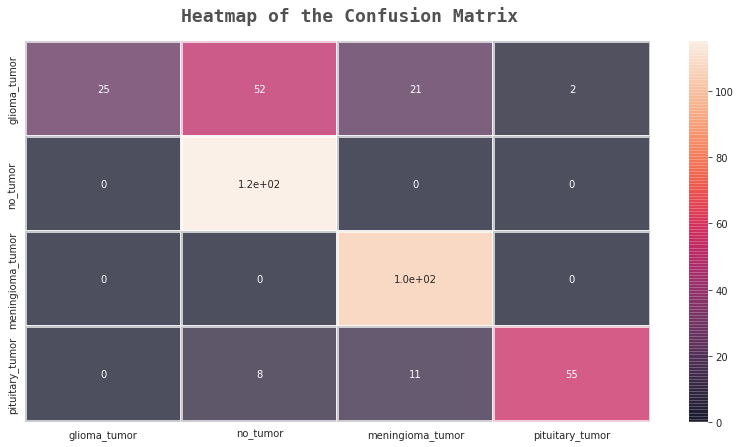

In [57]:
tumors = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
fig,ax=plt.subplots(1,1,figsize=(14,7))
sb.heatmap(confusion_matrix(test_data.label,test_pred),ax=ax,xticklabels=tumors,yticklabels=tumors,annot=True,
          alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

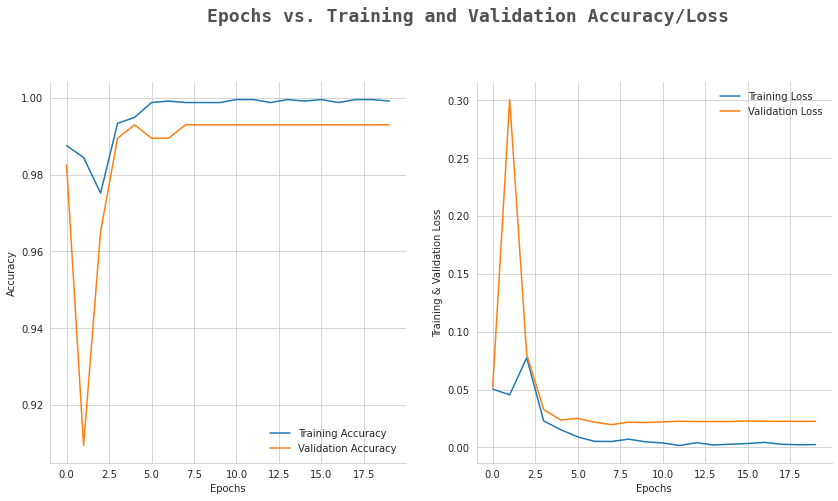

In [58]:
import seaborn as sb 
epochs = [i for i in range(20)]
figure, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

figure.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)
sb.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sb.despine()
ax[1].plot(epochs, train_loss, 
           label ='Training Loss')
ax[1].plot(epochs, val_loss, 
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

figure.show()

### Considerations
  AMAZING results from the model, with a staggering 99.5% accuracy, matching Model5, even though the glioma images got confused more than before. Meningioma and healthy brain scan images fared far better than before, and pituary scans also saw some increase in accuracy. This model pushed the previous conditions to the extreme, making more precise the measurements that were already good, and less precise the measurements that were already poor. 

## More uses - Gradcam and widgets
  Wanting to make the projects more interactive, and after a successful run using VGG16, I tried to make use of the GRADCAM module, which allows the user to visually see what the network detects as a tumor and how it identifies it. This is a really good applications as it allowed me to see where the problem with the glioma tumor images was. The darkest area of the images represent what the model defines as a tumor and where. 

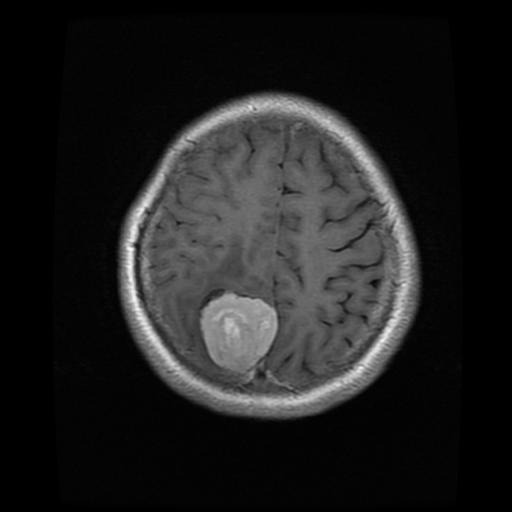

In [45]:

chosen_transfer = tf.keras.applications.vgg16.VGG16
resolution = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_layer = "block5_conv3"

path ='/content/gdrive/MyDrive/Notebooks/NNProject2/Training/meningioma_tumor/m (183).jpg'
display(Image(path))

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n04286575', 'spotlight', 7.1092734)]


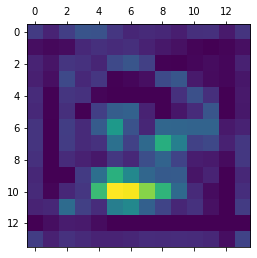

In [46]:
# 'img_from_array' is a function that takes as input parameters the path to the selected image, and the resolution of the image to return a numpy array of it.
def img_from_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # the next two lines standardize the image into a float numpy32 array, while also expanding its dimension to have the 'rgb' value of 3. 
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # The three dimensional array is returned. 
    return array

# 'night_vision' is a function that takes as input parameters the image array compiled earlier, the model (transfer in this case) that will be used, the type of last layer and a previous index.
# The goal of this function is to return the night vision heatmap of the provided image.
def night_vision(img_array, model, last_layer, pred_index=None):
    # Firstly, 'grad_model' represents the chosen transfer model. 
    # Subsequently, the model maps the image array to all the different activation functions, while adding the last layer to itself.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_layer).output, model.output])

    # The  gradient is then predicted using the activations of the last layer, with respect to the selected imageand the most predicted class.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # 'grads' is the last gradient, with respect to the feature map of the last layer. 
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #'pooled_grads' is an array where each element is the average intensity of the gradient over a specific channel of the aforementioned feature map.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Each channel in the map is multiplied by it's weight and with regarded to the top predicted class. 
    last_conv_layer_output = last_conv_layer_output[0]
    # The channels are all summed together then to obtain the final nightvision heatmap activation. 
    night_vision_heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    night_vision_heatmap = tf.squeeze(night_vision_heatmap)
    # Finally, for correct visualizations, the heatmap is standardized between 0 and 1. 
    night_vision_heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(night_vision_heatmap)
    return night_vision_heatmap.numpy()
 
 
image_array = preprocess_input(img_from_array(path, size = resolution))
model = chosen_transfer(weights = "imagenet")
model.layers[-1].activation = None
preds = model.predict(image_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
night_vision_heatmap = night_vision(image_array, model, last_layer)
 
plt.matshow(night_vision_heatmap)
plt.show()

# The image array is built using the function described earlier.
image_array = preprocess_input(img_from_array(path, size = resolution))
# The model is built using the modified chosen transfer AND defined last layer.
model = chosen_transfer(weights = "imagenet")
# The transfer layer's softmax is removed.
model.layers[-1].activation = None
# Predictions based on the model's inherited weights are made. This can be any number of elements ('shield', 'bubble' etc. it doesn't surve a purpose, but it is interesting to observe.)
preds = model.predict(image_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
# And the nightvision heatmap is displayed. 
night_vision_heatmap = night_vision(image_array, model, last_layer)

plt.matshow(night_vision_heatmap)
plt.show()

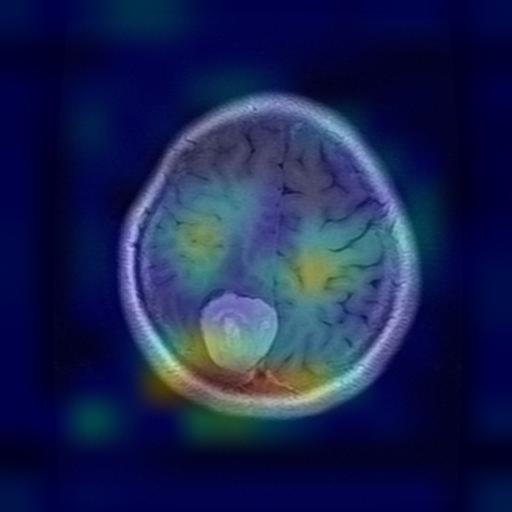

In [47]:
# 'show_gradcam' is a function in charge of placing the nightvision heatmap above the chosen image in order to obtain the final result.
# As input parameters, it takes the image path, the nightvision heatmpat, a path to which it will save it (if not using Google Colab) and the alpha value. 
def show_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # The input image is taken and preprocessed. 
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    # The image is then rescaled to a range of 0 to 255. 
    heatmap = np.uint8(255 * heatmap)
    # The 'jet' colormap represents the nightvision colors. 
    jet = cm.get_cmap("jet")
    # Which are then set to 'rgb' (the 3).
    jet_colors = jet(np.arange(256))[:, :3]
    # The following lines of code correctly place the nightvision heatmap above the image, to display the final results. 

    # More specifically, the following four lines of code create the housing for the final image, taking the original dataset image and converting it to 'rgb' 
    # And correctly resizing the nightvision heatmap.
    night_vision_heatmap = jet_colors[heatmap]
    night_vision_heatmap = keras.preprocessing.image.array_to_img(night_vision_heatmap)
    night_vision_heatmap = night_vision_heatmap.resize((img.shape[1], img.shape[0]))
    night_vision_heatmap = keras.preprocessing.image.img_to_array(night_vision_heatmap)
    # The subsequent three lines of code super impose the two images. 
    superimposed_img = night_vision_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    # And the final result is displayed. 
    display(Image(cam_path))

show_gradcam(path, heatmap)


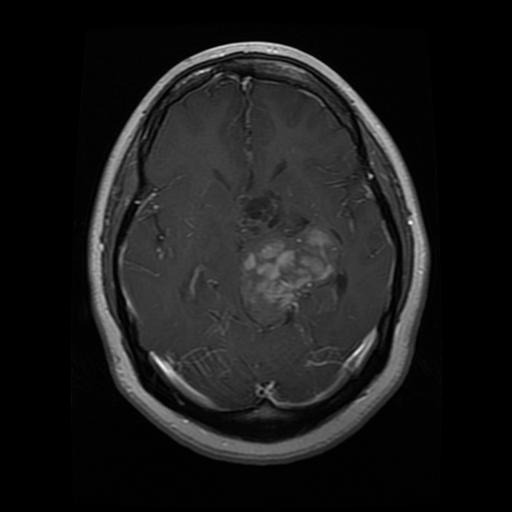

1/1 [==============================] - 2s 2s/step
Predicted: [('n09229709', 'bubble', 7.4754667)]


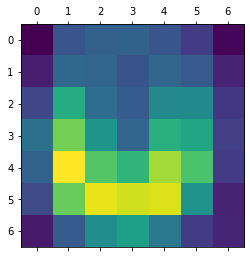

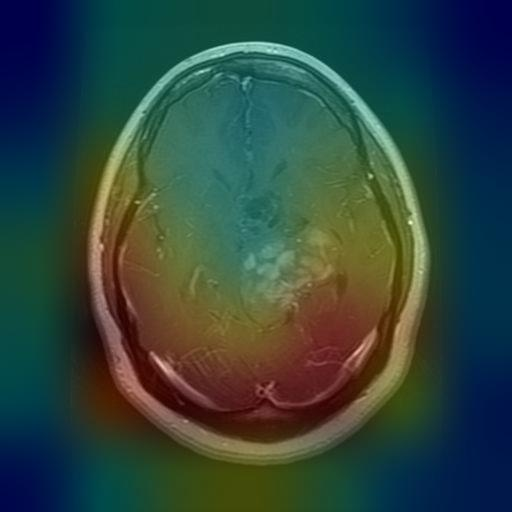

In [50]:
chosen_transfer = tf.keras.applications.efficientnet.EfficientNetB0
resolution = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions
last_layer = "top_conv"
path ='/content/gdrive/MyDrive/Notebooks/NNProject2/Training/glioma_tumor/gg (1).jpg'
display(Image(path))
image_array = preprocess_input(img_from_array(path, size=resolution))
model = chosen_transfer(weights="imagenet")
model.layers[-1].activation = None
preds = model.predict(image_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
night_vision_heatmap = night_vision(image_array, model, last_layer)
plt.matshow(night_vision_heatmap)
plt.show()
show_gradcam(path, night_vision_heatmap)

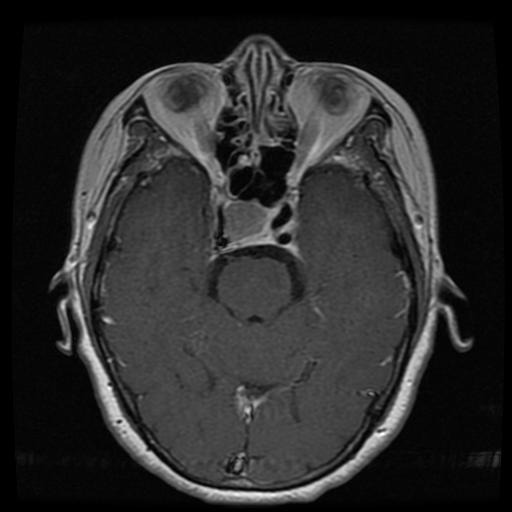

1/1 [==============================] - 2s 2s/step
Predicted: [('n04192698', 'shield', 6.908266)]


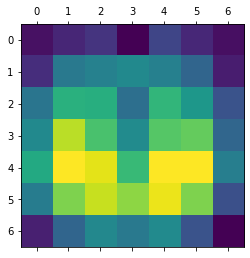

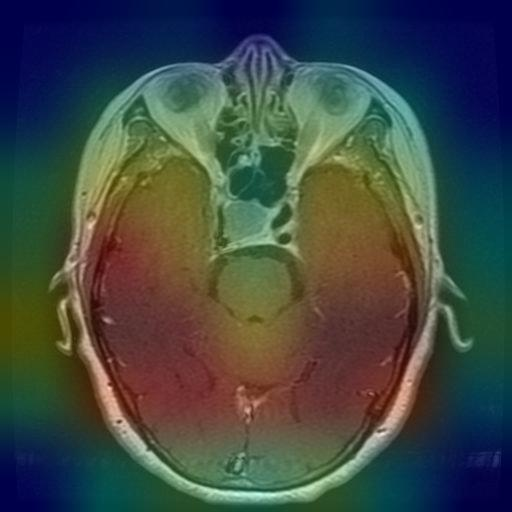

In [52]:
chosen_transfer = tf.keras.applications.efficientnet.EfficientNetB0
resolution = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions
last_layer = "top_conv"
path ='/content/gdrive/MyDrive/Notebooks/NNProject2/Training/pituitary_tumor/p (18).jpg'
display(Image(path))
image_array = preprocess_input(img_from_array(path, size = resolution))
model = chosen_transfer(weights="imagenet")
model.layers[-1].activation = None
preds = model.predict(image_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
night_vision_heatmap = night_vision(image_array, model, last_layer)
plt.matshow(night_vision_heatmap)
plt.show()
show_gradcam(path, night_vision_heatmap)

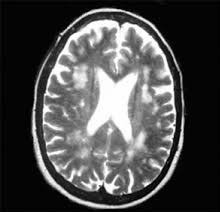

1/1 [==============================] - 2s 2s/step
Predicted: [('n02865351', 'bolo_tie', 7.83182)]


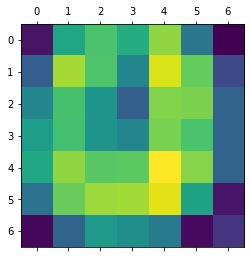

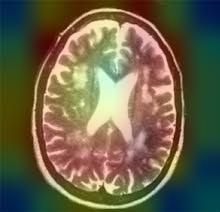

In [53]:
chosen_transfer = tf.keras.applications.efficientnet.EfficientNetB0
resolution = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions
last_layer = "top_conv"
path ='/content/gdrive/MyDrive/Notebooks/NNProject2/Training/no_tumor/8.jpg'
display(Image(path))
image_array = preprocess_input(img_from_array(path, size = resolution))
model = chosen_transfer(weights = "imagenet")
model.layers[-1].activation = None
preds = model.predict(image_array)
print("Predicted:", decode_predictions(preds, top=1)[0])
night_vision_heatmap = night_vision(image_array, model, last_layer)
plt.matshow(night_vision_heatmap)
plt.show()
show_gradcam(path, night_vision_heatmap)

### Upload your own image. 
With this widget, any correctly taken MRI screening can be placed in the model and run. This renders the project scalable and interactive, and it was really nice to test out. 

In [54]:
def predict_from_upload(upload):
    for name, path in uploader.value.items():
        chosenImage = Image.open(io.BytesIO(path['content']))
    cv_image = cv2.cvtColor(np.array(chosenImage), cv2.COLOR_RGB2BGR)
    chosenImage = cv2.resize(cv_image,(150,150))
    chosenImage = img.reshape(1,150,150,3)
    output = model.predict(chosenImage)
    output = np.argmax(p,axis=1)[0]
    if output == 0:
        output = 'Glioma Tumor'
    elif output == 1:
        print('The model predicts that there is no tumor')
    elif output == 2:
        output = 'Meningioma Tumor'
    else:
        output = 'Pituitary Tumor'
    if output != 1:
        print(f'The Model predicts that it is a {output}')

In [59]:
import ipywidgets as widgets
upload_mode = widgets.FileUpload()
display(upload_mode)

FileUpload(value={}, description='Upload')

In [60]:
from IPython.display import clear_output

button = widgets.Button(description='Predict')
output = widgets.Output()
def on_button_clicked(_):
    with output:
        clear_output()
        try:
            predict_from_upload(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,output])

# Conclusions
Most of the results were highly satisfactory; the bicategorical model could not be fully implemented to a quadricategorical model, but that was to be expected. Model5 obtained good results, while Model4 obtained great results (99.75% accuracy). 
Regarding the transfer models, EfficientNetB0 was the most successful model for quadricategorical predictions, beating VGG16. In addition, the implementation of the GRADCAM served to understand how the Neural Networks view the images, where they make predictions and they confirmed my suspicions regarding discrepancies in the data.
If the tumor images were more diverse, I am sure the models would have fared much better. This is the same for having more images per class. Considering the dataset size, and the similarities between images, I deem this project a success.

While Convolutional Neural Networks are not my favourite subject in the realm of Deep Learning, they are nevertheless a really interesting component of it. I showed this project to my girlfriend and she was really impressed, which I enjoyed. 